In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
import talib as ta
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [121]:
infy_dataset = pd.read_csv("complete_data_set_v1/INFY.NS.csv")

In [122]:
def data_preprocessing(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'],format='%Y-%m')
    dataset['Adj Close'] = pd.to_numeric(dataset['Adj Close'],errors='coerce')
    dataset['Volume'] = pd.to_numeric(dataset['Volume'],errors='coerce')
    dataset['Close'] = pd.to_numeric(dataset['Close'],errors='coerce')
    dataset['Low'] = pd.to_numeric(dataset['Low'],errors='coerce')
    dataset['High'] = pd.to_numeric(dataset['High'],errors='coerce')
    dataset['Open'] = pd.to_numeric(dataset['Open'],errors='coerce')
    
    '''remove rows with any null value'''
    dataset = dataset.dropna(axis=0,how='any')
    
    '''Create new column to show closing price after 30th day'''
    forecast_out = int(30) # predicting 30 days into future
    dataset['PriceNextMonth'] = dataset[['Adj Close']].shift(-forecast_out)
    dataset = dataset[:-forecast_out]# remove last 30 from X
    
    return dataset
    

In [123]:
def split_dataset(dataset,features,response):
    X = dataset[features]
    #X = X.values.reshape(X.shape[0],1)
    y = np.array(dataset[response])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 0)
    return X_train, X_test, y_train, y_test    

In [124]:
def evaluate_model(model,X_train, X_test, y_train, y_test):
    confidence = model.score(X_test, y_test)
    print("score: ", confidence)
    
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("cross_val_score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("mean_absolute_error: ", mae)
    #plt.plot(y_test)
    #plt.plot(y_pred, color='red')
    #plt.show()

In [367]:
'''def evaluate_random_forest(dataset,features,response):
    X_train, X_test, y_train, y_test = split_dataset(dataset,features,response)
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)
    evaluate_model(model,X_train, X_test, y_train, y_test)'''

'def evaluate_random_forest(dataset,features,response):\n    X_train, X_test, y_train, y_test = split_dataset(dataset,features,response)\n    model = RandomForestRegressor(random_state=0)\n    model.fit(X_train, y_train)\n    evaluate_model(model,X_train, X_test, y_train, y_test)'

In [450]:
def evaluate_random_forest(dataset,features,response):
    tscv = TimeSeriesSplit(n_splits=12)
    X = dataset[features].values
    y = np.array(dataset[response])
    index = 1
    total_mae = 0
    for train_index, test_index in tscv.split(dataset.values):
        #print('Observations: %d' % (len(train_index) + len(train_index)))
        #print('Training Observations: %d' % (len(train_index)))
        #print('Testing Observations: %d' % (len(test_index)))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestRegressor(random_state=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        print('Fold No: %d'% index)
        print("mean_absolute_error: ", mae)
        feature_importances = pd.DataFrame(model.feature_importances_,index = features,
                                    columns=['importance']).sort_values('importance',ascending=False)
        print(feature_importances)
        total_mae = total_mae+mae
        index += 1
    print("average MAE:",total_mae/index)
    #feature_importances = pd.DataFrame(model.feature_importances_,index = features,
    #                                columns=['importance']).sort_values('importance',ascending=False)
    #print(feature_importances)

In [379]:
processed_dataset = data_preprocessing(infy_dataset)
explore_dataset = processed_dataset.copy()

C:\Users\Vani\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [380]:
'''No feature Engineering'''
features = ["Adj Close"]
response = "PriceNextMonth"
explore_dataset_no_enginr = processed_dataset[["Adj Close","PriceNextMonth"]] 
#X_train, X_test, y_train, y_test = split_dataset(explore_dataset_no_enginr,features,response)
evaluate_random_forest(explore_dataset_no_enginr,features,response)

average MAE: 66.6375400194


In [381]:
explore_dataset["HL_Perc"] = (processed_dataset["High"]-processed_dataset["Low"]) / processed_dataset["Low"] * 100
explore_dataset["CO_Perc"] = (processed_dataset["Close"] - processed_dataset["Open"]) / processed_dataset["Open"] * 100

#so our dataset now conatins two new columnn and they are change from low to high 
#percentage and closed and open percentage
#we keep only those columns in our datasheet whih we need and remove the rest
explore_dataset = explore_dataset[["HL_Perc", "CO_Perc", "Adj Close","PriceNextMonth"]] 

In [382]:
features = ["HL_Perc", "CO_Perc", "Adj Close"]
response = "PriceNextMonth"
evaluate_random_forest(explore_dataset,features,response)

average MAE: 64.5992340999


In [383]:
'''Here MAE after feature engineering is 51.32 which is less from our base model MAE which is 53.86,
so we are going in correct direction.
Need to find more features to reduce MAE,we will use TA lib for that'''

'Here MAE after feature engineering is 51.32 which is less from our base model MAE which is 53.86,\nso we are going in correct direction.\nNeed to find more features to reduce MAE,we will use TA lib for that'

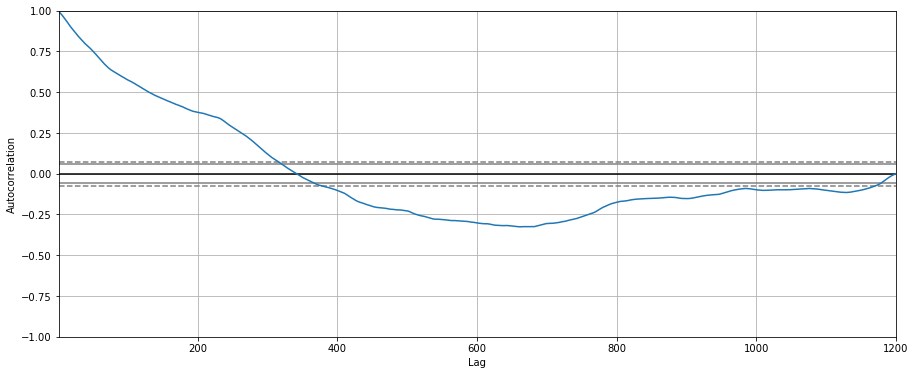

In [384]:
autocorrelation_plot(processed_dataset['Adj Close'])
plt.show()

In [385]:
'''From graph it is clear that Adj Close price is autocorrelated and correlation decreases after 75-100 days
So we will do TA between 0-100 days,not more than that'''

'From graph it is clear that Adj Close price is autocorrelated and correlation decreases after 75-100 days\nSo we will do TA between 0-100 days,not more than that'

In [386]:
'''Let us create numpy array for TA '''
high = processed_dataset['High'].values
low = processed_dataset['Low'].values
close = processed_dataset['Close'].values
open = processed_dataset['Open'].values
volume = processed_dataset['Volume'].values

In [438]:
#1 Simple Moving Average (30,40,50 Days)
SMA = ta.SMA(close, 30)
SMA_dataset = processed_dataset.copy()
SMA_dataset["SMA"] = SMA
SMA_dataset = SMA_dataset[["Adj Close","SMA","PriceNextMonth"]] 
SMA_dataset = SMA_dataset.dropna(axis=0,how='any')
features = ["Adj Close","SMA"]
response = "PriceNextMonth"
evaluate_random_forest(SMA_dataset,features,response)
'''
MAE for SMA 30=68.1949023014
MAE for SMA 40=72.0747132953
MAE for SMA 50=74.4814882069
Hence,SMA 30 can be considered for feature addition
'''

average MAE: 68.1949023014


'\nMAE for SMA 30=68.1949023014\nMAE for SMA 40=72.0747132953\nMAE for SMA 50=74.4814882069\nHence,SMA 30 can be considered for feature addition\n'

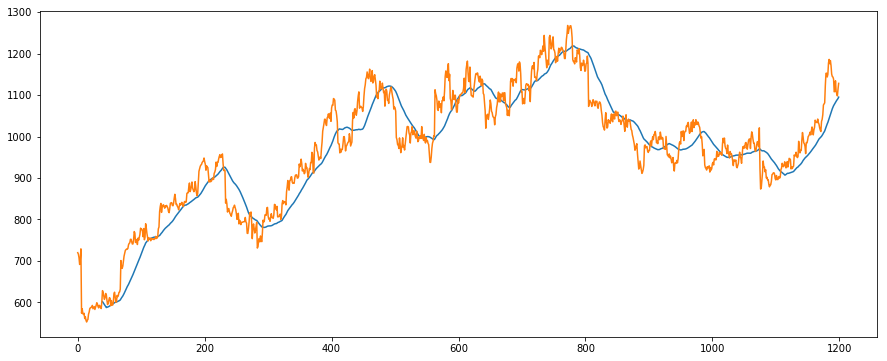

In [391]:
plt.plot(SMA)
plt.plot(close)

In [396]:
#2 Exponential Moving Average (30,40,50 days)
EMA = ta.EMA(close, 30)
EMA_dataset = processed_dataset.copy()
EMA_dataset["EMA"] = EMA
EMA_dataset = EMA_dataset[["Adj Close","EMA","PriceNextMonth"]] 
EMA_dataset = EMA_dataset.dropna(axis=0,how='any')
features = ["Adj Close","EMA"]
response = "PriceNextMonth"
evaluate_random_forest(EMA_dataset,features,response)
'''
MAE for EMA 30=69.722432579
MAE for EMA 40=71.8504120853
MAE for EMA 50=73.4975742016
Hence,EMA 30 can be considered for feature addition
'''

average MAE: 73.4975742016


'\nMAE for EMA 30=69.722432579\nMAE for EMA 40=71.8504120853\nMAE for EMA 50=27.9178534736\nHence,EMA 40 can be considered for feature addition\n'

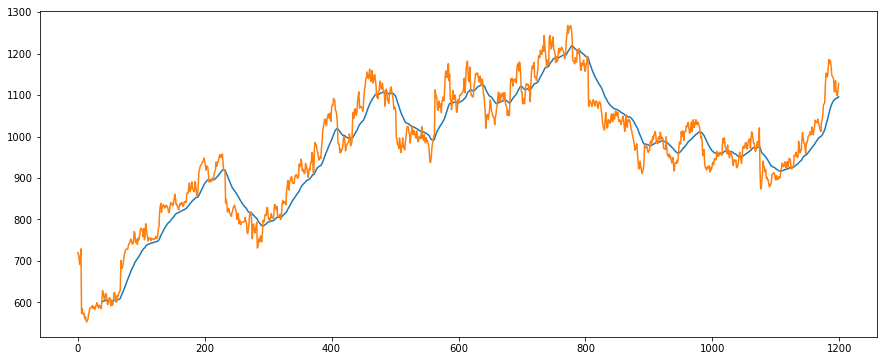

In [393]:
plt.plot(EMA)
plt.plot(close)

In [400]:
#3 Aroon Oscillator (30,40,50 Days)
AROONOSC = ta.AROONOSC(high, low, timeperiod=30)
AROONOSC_dataset = processed_dataset.copy()
AROONOSC_dataset["AROONOSC"] = AROONOSC
AROONOSC_dataset = AROONOSC_dataset[["Adj Close","AROONOSC","PriceNextMonth"]] 
AROONOSC_dataset = AROONOSC_dataset.dropna(axis=0,how='any')
features = ["Adj Close","AROONOSC"]
response = "PriceNextMonth"
evaluate_random_forest(AROONOSC_dataset,features,response)
'''
MAE for AROONOSC 30=68.2690515159
MAE for AROONOSC 40=74.4092875626
MAE for AROONOSC 50=77.348689388
Hence,AROONOSC 30 can be considered for feature addition
'''

average MAE: 68.2690515159


'\nMAE for AROONOSC 30=68.2690515159\nMAE for AROONOSC 40=74.4092875626\nMAE for AROONOSC 50=77.348689388\nHence,AROONOSC 50 can be considered for feature addition\n'

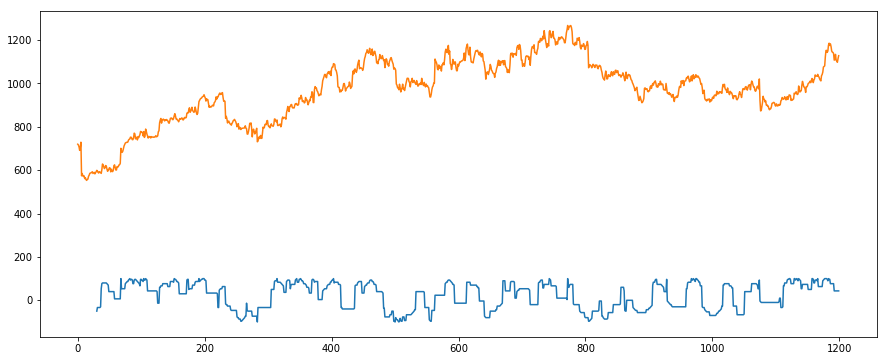

In [401]:
plt.plot(AROONOSC)
plt.plot(close)

In [402]:
#4 MACD - Moving Average Convergence/Divergence
macd, macdsignal, macdhist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
MACD_dataset = processed_dataset.copy()
MACD_dataset["macd"] = macd
MACD_dataset = MACD_dataset[["Adj Close","macd","PriceNextMonth"]] 
MACD_dataset = MACD_dataset.dropna(axis=0,how='any')
features = ["Adj Close","macd"]
response = "PriceNextMonth"
evaluate_random_forest(MACD_dataset,features,response)

average MAE: 67.6455053667


In [403]:
#5 Relative Strength Index (RSI)
RSI = ta.RSI(close, timeperiod=14)
RSI_dataset = processed_dataset.copy()
RSI_dataset["RSI"] = RSI
RSI_dataset = RSI_dataset[["Adj Close","RSI","PriceNextMonth"]] 
RSI_dataset = RSI_dataset.dropna(axis=0,how='any')
features = ["Adj Close","RSI"]
response = "PriceNextMonth"
evaluate_random_forest(RSI_dataset,features,response)

average MAE: 67.9910293329


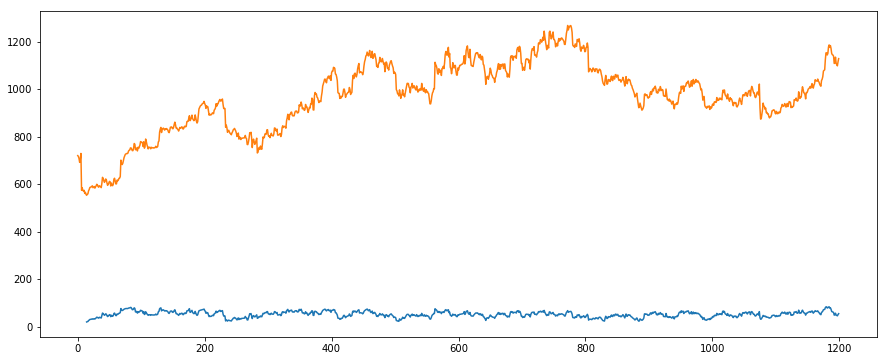

In [404]:
plt.plot(RSI)
plt.plot(close)

In [408]:
#6 Bollinger Bands ( 30, 40, 50 Days)
upperband, middleband, lowerband = ta.BBANDS(close, timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
BBANDS_dataset = processed_dataset.copy()
BBANDS_dataset["upperband"] = upperband
BBANDS_dataset["middleband"] = middleband
BBANDS_dataset["lowerband"] = lowerband
BBANDS_dataset = BBANDS_dataset[["Adj Close","upperband","middleband","lowerband","PriceNextMonth"]] 
BBANDS_dataset = BBANDS_dataset.dropna(axis=0,how='any')
features = ["Adj Close","upperband","middleband","lowerband"]
response = "PriceNextMonth"
evaluate_random_forest(BBANDS_dataset,features,response)
'''
MAE for BBANDS 30=69.2850691405
MAE for BBANDS 40=70.4524357974
MAE for BBANDS 50=77.3168054141
Hence,BBANDS 30 can be considered for feature addition
'''


average MAE: 69.2850691405


'\nMAE for BBANDS 30=69.2850691405\nMAE for BBANDS 40=70.4524357974\nMAE for BBANDS 50=77.3168054141\nHence,BBANDS 30 can be considered for feature addition\n'

'too erratic to use for feature engineering'

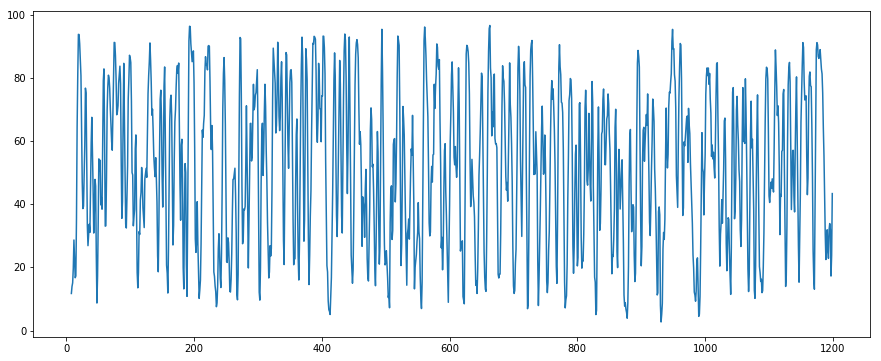

In [409]:
#7 Stochastic Oscillator
slowk, slowd = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
plt.plot(slowk)
#plt.plot(slowd)
'''too erratic to use for feature engineering'''

In [410]:
#8 Stochastic momentum Indicator
'''TA lib does not have support for this'''


'TA lib does not have support for this'

In [416]:
#9 Chande Momentum Oscillator
CMO = ta.CMO(close, timeperiod=10)
CMO_dataset = processed_dataset.copy()
CMO_dataset["CMO"] = CMO
CMO_dataset = CMO_dataset[["Adj Close","CMO","PriceNextMonth"]] 
CMO_dataset = CMO_dataset.dropna(axis=0,how='any')
features = ["Adj Close","CMO"]
response = "PriceNextMonth"
evaluate_random_forest(CMO_dataset,features,response)
'''
MAE for CMO 10=64.6103485069
MAE for CMO 20=69.9060499261
MAE for CMO 30=72.9123027451
Hence,CMO 10 can be considered for feature addition
'''


average MAE: 64.6103485069


'\nMAE for CMO 10=64.6103485069\nMAE for CMO 20=69.9060499261\nMAE for CMO 30=72.9123027451\nHence,CMO 10 can be considered for feature addition\n'

In [421]:
# 10 Commodity Channel Index ( 30, 40, 50 Days)
CCI = ta.CCI(high, low, close, timeperiod=50)
CCI_dataset = processed_dataset.copy()
CCI_dataset["CCI"] = CCI
CCI_dataset = CCI_dataset[["Adj Close","CCI","PriceNextMonth"]] 
CCI_dataset = CCI_dataset.dropna(axis=0,how='any')
features = ["Adj Close","CCI"]
response = "PriceNextMonth"
evaluate_random_forest(CCI_dataset,features,response)
'''
MAE for CCI 30=68.348768302
MAE for CCI 40=69.351555898
MAE for CCI 50=68.8940906645
Hence,CCI 50 can be considered for feature addition
'''


average MAE: 68.8940906645


'\nMAE for CCI 30=68.348768302\nMAE for CCI 40=69.351555898\nMAE for CCI 50=68.8940906645\nHence,CCI 50 can be considered for feature addition\n'

In [425]:
#11 Chaikin Volatility indicator ( 30, 40, 50 Days)
ADOSC = ta.ADOSC(high, low, close, volume, fastperiod=50, slowperiod=10)
ADOSC_dataset = processed_dataset.copy()
ADOSC_dataset["ADOSC"] = ADOSC
ADOSC_dataset = ADOSC_dataset[["Adj Close","ADOSC","PriceNextMonth"]] 
ADOSC_dataset = ADOSC_dataset.dropna(axis=0,how='any')
features = ["Adj Close","ADOSC"]
response = "PriceNextMonth"
evaluate_random_forest(ADOSC_dataset,features,response)
'''
MAE for ADOSC 30=71.9677676913
MAE for ADOSC 40=70.0801544604
MAE for ADOSC 50=67.796619938
Hence,ADOSC 50 can be considered for feature addition
'''

average MAE: 67.796619938


'\nMAE for ADOSC 30=71.9677676913\nMAE for ADOSC 40=70.0801544604\nMAE for ADOSC 50=67.796619938\nHence,ADOSC 50 can be considered for feature addition\n'

In [426]:
#12 Trend Detection Index (30, 40, 50 Days)
'''no support in TA lib'''

'no support in TA lib'

In [430]:
#13 Rate of Price Change (30, 40, 50 Days)
ROCR100 = ta.ROCR100(close, timeperiod=40)
ROCR100_dataset = processed_dataset.copy()
ROCR100_dataset["ROCR100"] = ROCR100
ROCR100_dataset = ROCR100_dataset[["Adj Close","ROCR100","PriceNextMonth"]] 
ROCR100_dataset = ROCR100_dataset.dropna(axis=0,how='any')
features = ["Adj Close","ROCR100"]
response = "PriceNextMonth"
evaluate_random_forest(ROCR100_dataset,features,response)
'''
MAE for ROCR100 30=70.1454457834
MAE for ROCR100 40=66.8279013461
MAE for ROCR100 50=68.2277861186
Hence,ROCR100 40 can be considered for feature addition
'''

average MAE: 66.8279013461


'\nMAE for ROCR100 30=70.1454457834\nMAE for ROCR100 40=66.8279013461\nMAE for ROCR100 50=68.2277861186\nHence,ROCR100 40 can be considered for feature addition\n'

In [431]:
#14 Rate of Volume Change (30, 40, 50 Days)
'''no support in TA lib'''


'no support in TA lib'

In [435]:
#15 William % R (30, 40, 50 Days)
WILLR = ta.WILLR(high, low, close, timeperiod=50)
WILLR_dataset = processed_dataset.copy()
WILLR_dataset["WILLR"] = WILLR
WILLR_dataset = WILLR_dataset[["Adj Close","WILLR","PriceNextMonth"]] 
WILLR_dataset = WILLR_dataset.dropna(axis=0,how='any')
features = ["Adj Close","WILLR"]
response = "PriceNextMonth"
evaluate_random_forest(WILLR_dataset,features,response)
'''
MAE for WILLR 30=71.9593511651
MAE for WILLR 40=72.1156726426
MAE for WILLR 50=69.2776663764
Hence,WILLR 50 can be considered for feature addition
'''

average MAE: 69.2776663764


'\nMAE for WILLR 30=71.9593511651\nMAE for WILLR 40=72.1156726426\nMAE for WILLR 50=69.2776663764\nHence,WILLR 50 can be considered for feature addition\n'

In [259]:
'''Features identified:
1.High-low change
HL_Perc = (high-low) / low * 100
2.Close -Open change
CO_Perc = (close - open) / open * 100
3.Simple Moving Average ( 50 Days)
SMA = ta.SMA(close, 50)
4.Exponential Moving Average (40 days)
EMA = ta.EMA(close, 40)
5.Aroon Oscillator (50 Days)
AROONOSC = ta.AROONOSC(high, low, timeperiod=50)
6.Bollinger Bands (50 Days)
upperband, middleband, lowerband = ta.BBANDS(close, timeperiod=50, nbdevup=2, nbdevdn=2, matype=0)
7.Chande Momentum Oscillator
CMO = ta.CMO(close, timeperiod=30)
8.Commodity Channel Index (50 Days)
CCI = ta.CCI(high, low, close, timeperiod=50)
9.Chakin Volatility indicator (40 Days)
ADOSC = ta.ADOSC(high, low, close, volume, fastperiod=40, slowperiod=10)
10.Rate of Price Change (30 Days)
ROCR100 = ta.ROCR100(close, timeperiod=30)
11.William % R (50 Days)
WILLR = ta.WILLR(high, low, close, timeperiod=50)'''

'Features identified:\n1.High-low change\nHL_Perc = (high-low) / low * 100\n2.Close -Open change\nCO_Perc = (close - open) / open * 100\n3.Simple Moving Average ( 50 Days)\nSMA = ta.SMA(close, 50)\n4.Exponential Moving Average (40 days)\nEMA = ta.EMA(close, 40)\n5.Aroon Oscillator (50 Days)\nAROONOSC = ta.AROONOSC(high, low, timeperiod=50)\n6.Bollinger Bands (50 Days)\nupperband, middleband, lowerband = ta.BBANDS(close, timeperiod=50, nbdevup=2, nbdevdn=2, matype=0)\n7.Chande Momentum Oscillator\nCMO = ta.CMO(close, timeperiod=30)\n8.Commodity Channel Index (50 Days)\nCCI = ta.CCI(high, low, close, timeperiod=50)\n9.Chakin Volatility indicator (40 Days)\nADOSC = ta.ADOSC(high, low, close, volume, fastperiod=40, slowperiod=10)\n10.Rate of Price Change (30 Days)\nROCR100 = ta.ROCR100(close, timeperiod=30)\n11.William % R (50 Days)\nWILLR = ta.WILLR(high, low, close, timeperiod=50)'

In [513]:
test_dataset = processed_dataset.copy()
test_dataset["HL_Perc"] = (high-low) / low * 100#average MAE: 64.4633232001
test_dataset["CO_Perc"] = (close - open) / open * 100
#test_dataset["SMA"] = ta.SMA(close, 30)
#test_dataset["EMA"] = ta.EMA(close, 30)
test_dataset["AROONOSC"] = ta.AROONOSC(high, low, timeperiod=30)
#upperband, middleband, lowerband = ta.BBANDS(close, timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
#test_dataset["upperband"] = upperband
#test_dataset["middleband"] = middleband
#test_dataset["lowerband"] = lowerband
test_dataset["CMO"] = ta.CMO(close, timeperiod=5)
#test_dataset["CCI"] = ta.CCI(high, low, close, timeperiod=10)
test_dataset["ADOSC"] = ta.ADOSC(high, low, close, volume, fastperiod=50, slowperiod=10)
test_dataset["ROCR100"] = ta.ROCR100(close, timeperiod=20)
test_dataset["WILLR"] = ta.WILLR(high, low, close, timeperiod=20)
test_dataset = test_dataset[["Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR","PriceNextMonth"]] 
#test_dataset = test_dataset[["Adj Close","HL_Perc","CO_Perc","SMA","EMA","AROONOSC","upperband","middleband","lowerband","CMO","CCI","ADOSC","ROCR100","WILLR","PriceNextMonth"]] 
test_dataset = test_dataset.dropna(axis=0,how='any')
features = ["Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR"]
response = "PriceNextMonth"
evaluate_random_forest(test_dataset,features,response)

Fold No: 1
mean_absolute_error:  58.6329161125
           importance
ADOSC        0.558656
Adj Close    0.295881
AROONOSC     0.048500
ROCR100      0.034887
HL_Perc      0.023596
CO_Perc      0.016108
CMO          0.014368
WILLR        0.008004
Fold No: 2
mean_absolute_error:  35.1133662091
           importance
Adj Close    0.676166
ADOSC        0.142021
AROONOSC     0.113272
ROCR100      0.023364
WILLR        0.020442
CMO          0.013115
CO_Perc      0.006902
HL_Perc      0.004718
Fold No: 3
mean_absolute_error:  157.004993794
           importance
Adj Close    0.640439
ADOSC        0.118833
AROONOSC     0.093281
ROCR100      0.068474
CMO          0.045573
WILLR        0.023293
HL_Perc      0.006022
CO_Perc      0.004084
Fold No: 4
mean_absolute_error:  64.7212648239
           importance
Adj Close    0.864504
ADOSC        0.033582
ROCR100      0.032320
AROONOSC     0.027217
CMO          0.024713
WILLR        0.008203
HL_Perc      0.007689
CO_Perc      0.001772
Fold No: 5
mean_abso

In [ ]:
'''By observing all model in CV,following are important features:
"Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR"                     
'''

In [ ]:
'''Now we have features,we will use them on different model,try to get best model'''